<a href="https://colab.research.google.com/github/Giovanna-de-Oliveira/LH_CD_SEUNOME/blob/main/EDA_and_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Carregando e Explorando os Dados#

                                    Series_Title  Released_Year Certificate  \
0                                  The Godfather           1972           A   
1                                The Dark Knight           2008          UA   
2                         The Godfather: Part II           1974           A   
3                                   12 Angry Men           1957           U   
4  The Lord of the Rings: The Return of the King           2003           U   

   Runtime  IMDB_Rating                                           Overview  \
0      175          9.2  An organized crime dynasty's aging patriarch t...   
1      152          9.0  When the menace known as the Joker wreaks havo...   
2      202          9.0  The early life and career of Vito Corleone in ...   
3       96          9.0  A jury holdout attempts to prevent a miscarria...   
4      201          8.9  Gandalf and Aragorn lead the World of Men agai...   

   Meta_score  Director  Star1  Star2  Star3  Star4  No_

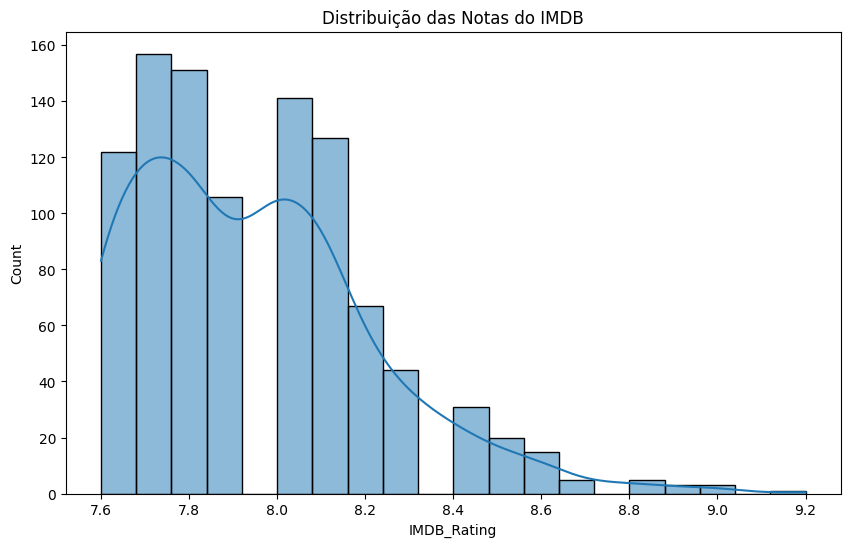

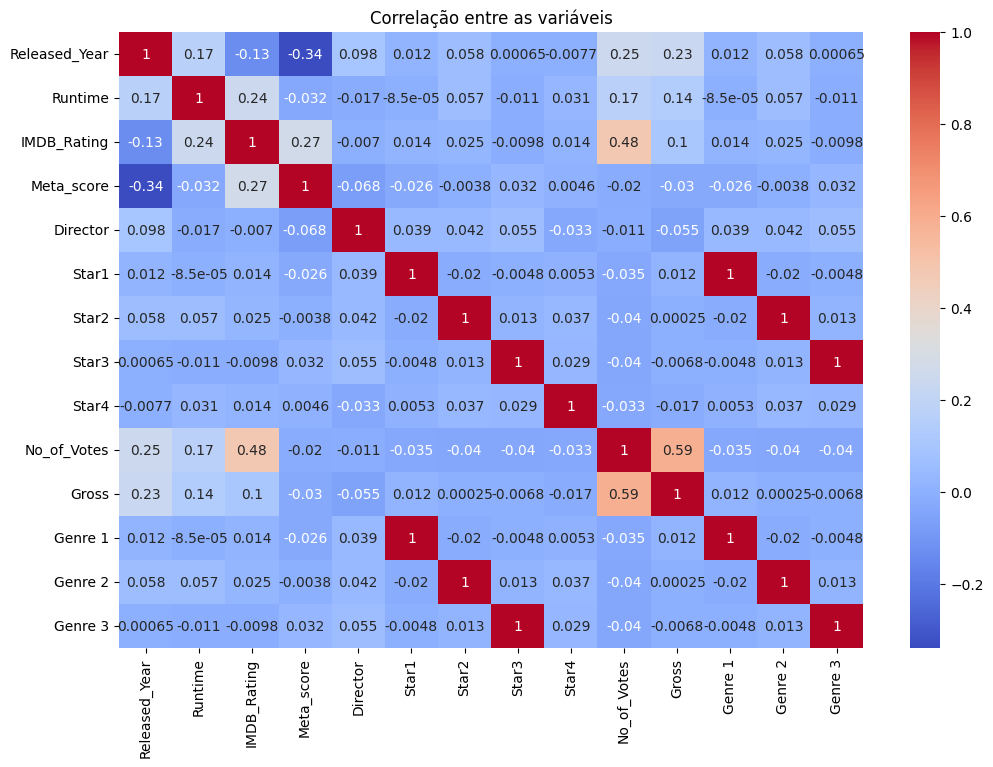

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pickle

# Carregar os dados
df = pd.read_csv('/content/desafio_indicium_imdb.csv')

#Apagar coluna de índice
df = df.drop(columns=['Unnamed: 0'])

# Separar os valores de 'Genre' em diferentes colunas
df_sep = df['Genre'].str.split(',', expand=True)

df_sep  = df_sep.rename(columns={0: 'Genre 1'})
df_sep  = df_sep.rename(columns={1: 'Genre 2'})
df_sep  = df_sep.rename(columns={2: 'Genre 3'})


df = pd.concat([df, df_sep], axis=1)
df.drop(columns=['Genre'], inplace=True)


#Tratamento dos dados para transformar em variável numérica

#VAriáveis que já eram número, tratadas apenas para ficar numéricas no dataframe

df['Gross'] = df['Gross'].str.replace(",", "")
df['Gross'] = pd.to_numeric(df['Gross'])

df['Released_Year'] = df['Released_Year'].replace('PG', np.nan)
df.dropna(subset=['Released_Year'], inplace=True)
df['Released_Year'] = pd.to_numeric(df['Released_Year'])

df['Runtime'] = df['Runtime'].str.replace(" min", "")
df['Runtime'] = pd.to_numeric(df['Runtime'])

#Variáveis textuais de categoria e valores recorrentes trasnformads em numéricas pela função nativa do pandas

df['Director'] = df['Director'].astype('category').cat.codes

df['Star1'] = df['Star1'].astype('category').cat.codes
df['Star2'] = df['Star2'].astype('category').cat.codes
df['Star3'] = df['Star3'].astype('category').cat.codes
df['Star4'] = df['Star4'].astype('category').cat.codes

df['Genre 1'] = df['Star1'].astype('category').cat.codes
df['Genre 2'] = df['Star2'].astype('category').cat.codes
df['Genre 3'] = df['Star3'].astype('category').cat.codes



# Visualizar os primeiros registros
print(df.head())

# Análise descritiva
print(df.describe())
print(df.dtypes)

# Verificar valores ausentes
print(df.isnull().sum())

# Selecionando apenas as colunas tratadas
numeric_df = df.select_dtypes(include=[np.number])

# Visualização de distribuições
plt.figure(figsize=(10, 6))
sns.histplot(df['IMDB_Rating'], kde=True)
plt.title('Distribuição das Notas do IMDB')
plt.show()
print("\n")

# Visualização de correlações
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre as variáveis')
plt.show()

Dada a análise dos gráfico de  distribuição das notas IMDB e a correlação entre as variáveis tenho pontos a destacar.

Percebo que a maior parte das notas IMDB estão divididas entre dois intervalos de 7.6 a 7.9  e 8.0 a 8.3. Isso significa que a maior parte das predições estarão nesses intervalos.   

Já com relação a variáveis para predição do IMDB são as mais relevantes, em sequência, o número de votos, a média ponderada de todas as críticas e tempo de duração. Por conta da baixa correlação com IMDB de outras característica, espera-se que sejam pouco relevantes na predição.

Outro ponto de análise é que poderia ser imaginado que o diretor teria muita relação com o IMDB do filme, já que muitos filmes com alta pontuação a primeira vista parecem se concentrar em poucos diretores, mas com essa análise mais profundo e pautada na base completa, foi possível perceber esse engano.

#Resposta às Perguntas

## a. Recomendação de um Filme



In [101]:
# Filme com alta nota no IMDB e muitos votos
recommended_movie = df[df['IMDB_Rating'] == df['IMDB_Rating'].max()]['Series_Title'].values[0]
print(f"Recomendo o filme: {recommended_movie}")


Recomendo o filme: The Godfather


Considerando que a pessoa que estou recomendando o filme não seja próxima a mim, recomendaria os filmes por seu IMDB, pois com altas notas, a chance do filme ser bom é grande.

Entretanto, penso que, caso soubesse o gosto da pessoa, recomendaria o filme de maior IMDB de seu gênero favorito.

## b. Fatores Relacionados ao Faturamento



In [102]:
#Correlação com faturamento

correlation_with_gross = numeric_df.corr()['Gross'].sort_values(ascending=False)
print(correlation_with_gross)


Gross            1.000000
No_of_Votes      0.590015
Released_Year    0.233270
Runtime          0.139434
IMDB_Rating      0.100980
Genre 1          0.011545
Star1            0.011545
Genre 2          0.000251
Star2            0.000251
Genre 3         -0.006802
Star3           -0.006802
Star4           -0.016986
Meta_score      -0.030452
Director        -0.054770
Name: Gross, dtype: float64


Como visto anteriormente no gráfico de correlação, o número de votos possui a maior relação com o faturamento do filme. Apenas com os dados não consigo explicar o porque.

Entretanto, acredito que a segunda maior correlação, ano de lançamento, ocorra devido ao momento econômico do lançamento. Períodos mais estáveis da economia tornam mais propícios as pessoas gastarem com lazer, nesse caso, indo ao cinema para assistir o filme.

## c. Insights da Coluna Overview



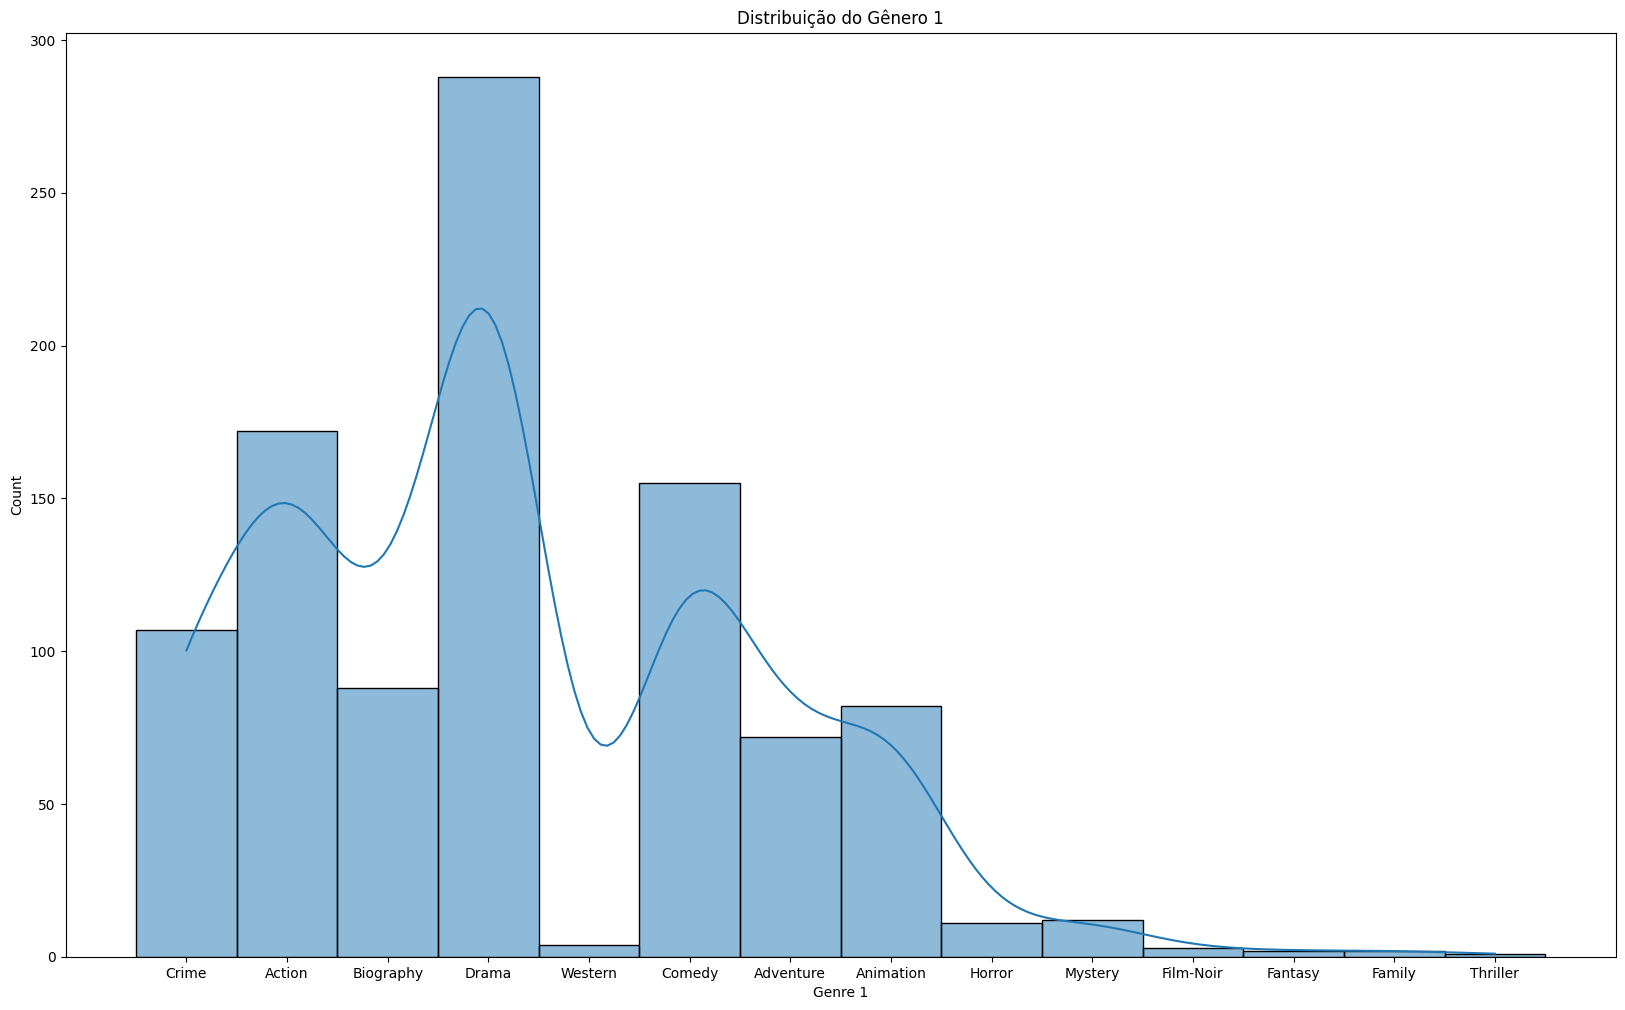

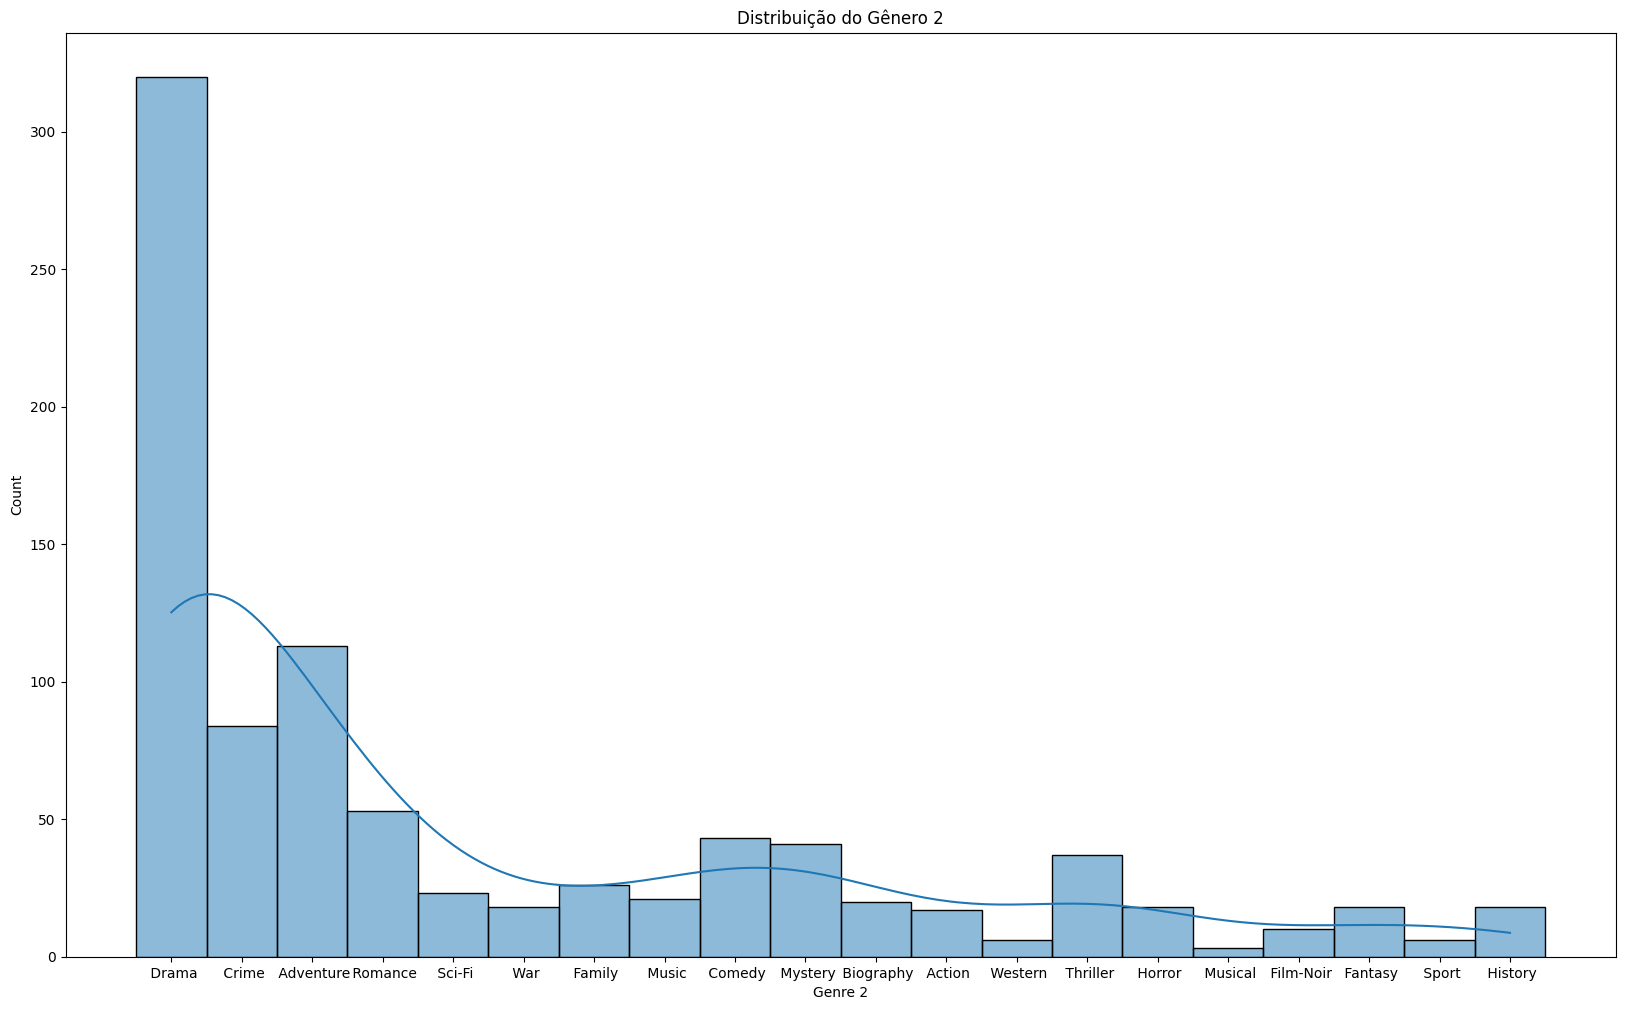

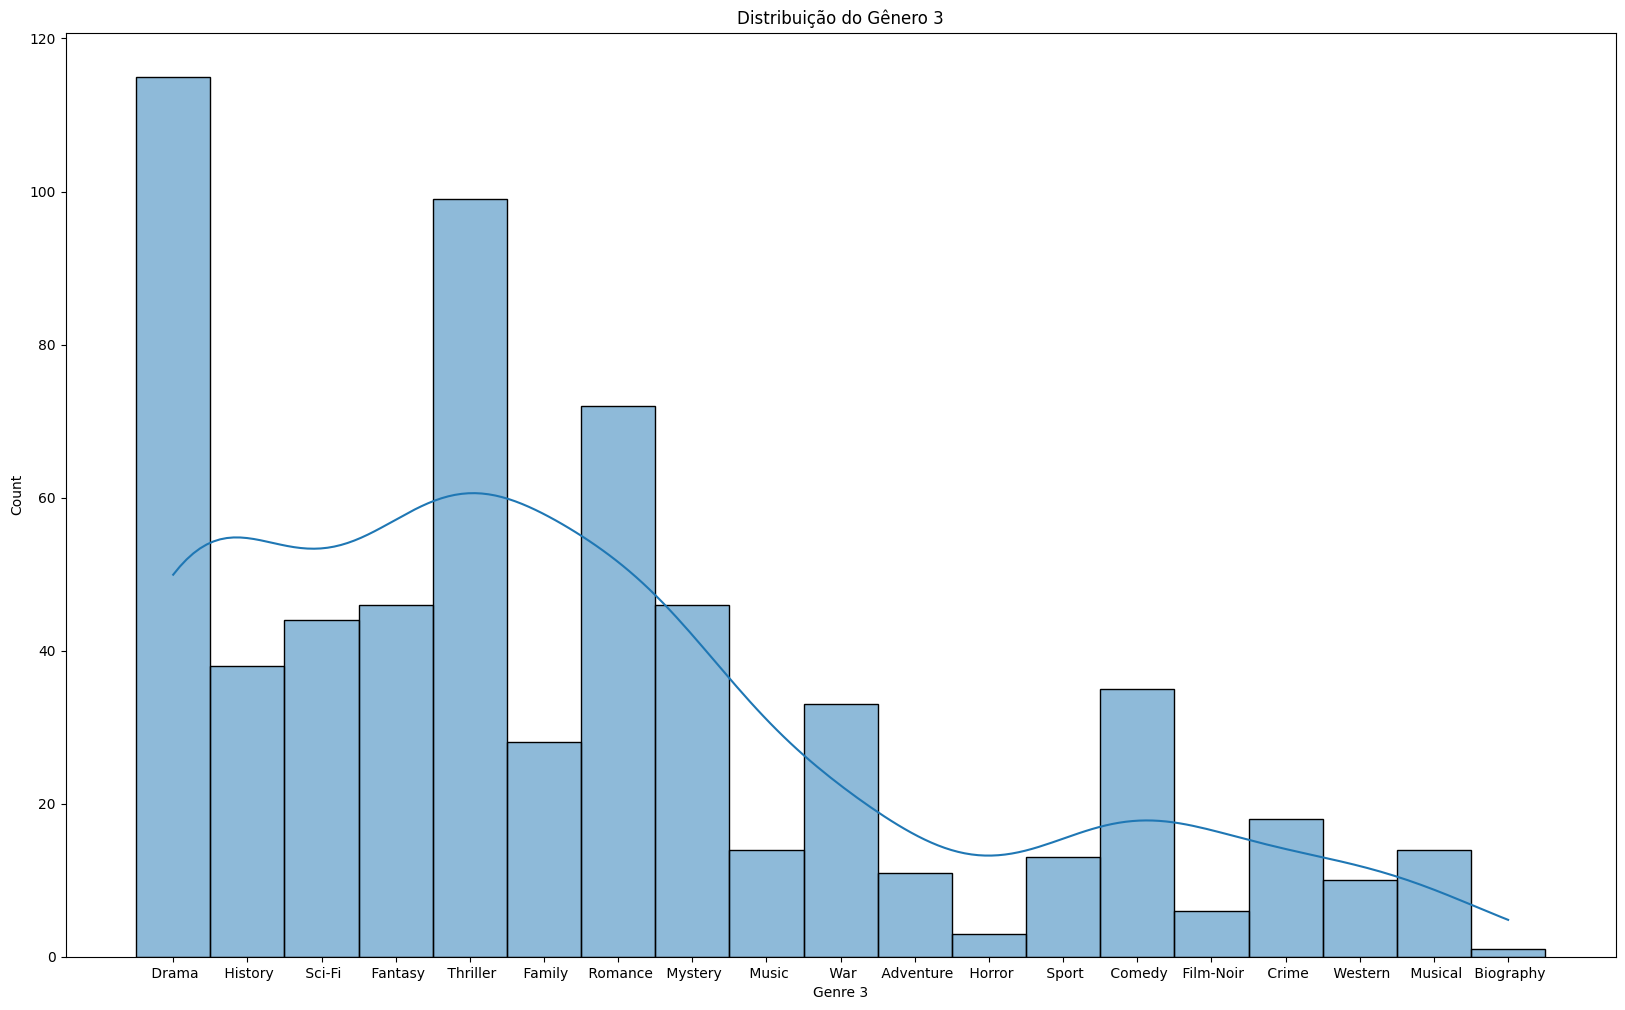

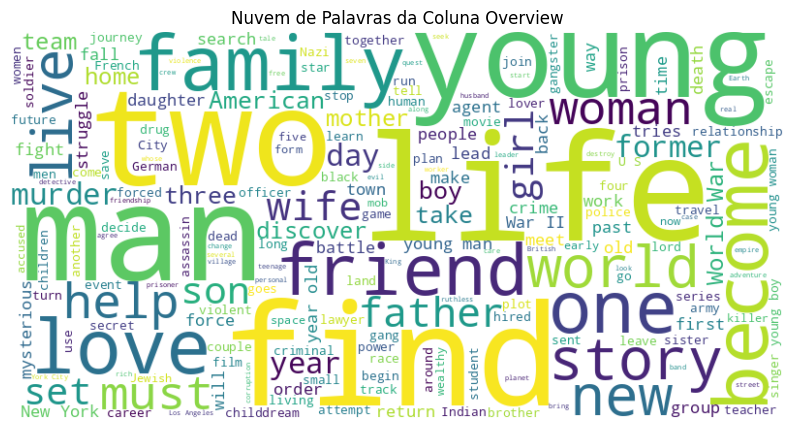

In [103]:
from wordcloud import WordCloud
# Carregar os dados
df = pd.read_csv('/content/desafio_indicium_imdb.csv')

#Apagar coluna de índice
df = df.drop(columns=['Unnamed: 0'])

# Separar os valores de 'Genre' em diferentes colunas
df_sep = df['Genre'].str.split(',', expand=True)

df_sep  = df_sep.rename(columns={0: 'Genre 1'})
df_sep  = df_sep.rename(columns={1: 'Genre 2'})
df_sep  = df_sep.rename(columns={2: 'Genre 3'})


df = pd.concat([df, df_sep], axis=1)
df.drop(columns=['Genre'], inplace=True)

# Verificar os gêneros mais comuns dos filmes

plt.figure(figsize=(20, 12))
sns.histplot(df['Genre 1'], kde=True)
plt.title('Distribuição do Gênero 1')
plt.show()
print("\n")

plt.figure(figsize=(20, 12))
sns.histplot(df['Genre 2'], kde=True)
plt.title('Distribuição do Gênero 2')
plt.show()
print("\n")

plt.figure(figsize=(20, 12))
sns.histplot(df['Genre 3'], kde=True)
plt.title('Distribuição do Gênero 3')
plt.show()
print("\n")

# Gerar uma nuvem de palavras para a coluna Overview
overview_text = ' '.join(df['Overview'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(overview_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras da Coluna Overview')
plt.show()


Utilizando uma nuvem de palavras para melhor visualização, é possível perceber que os tópicos mais aparentes tem relação com relacionamentos, vida e humanidade.

O Gênero drama possui essa questões em sua maioria e através da contagem no dataset, foi visto que esse gênero foi o mais recorrente.

Logo sim, é possível deduzir o filme através de seu overview